In [1]:
import time
import os
import h5py
import math
from pprint import pprint

import scipy.io 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, LeakyReLU
from tensorflow.keras import Model

TensorFlow version: 2.6.0
Name: /physical_device:GPU:0   Type: GPU


In [2]:
rawdata = scipy.io.loadmat("data/TrainData")
print(type(rawdata))
print(list(rawdata.keys()))
particle = np.array(rawdata['TrainData'])
print(particle.shape)
pprint(particle[:,0])

<class 'dict'>
['__header__', '__version__', '__globals__', 'TrainData']
(9, 2000)
array([1.66000000e+02, 1.41000000e+02, 3.50000000e+01, 5.59348234e-01,
       1.22520000e+04, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00])


# TrainData

1. x
2. y
3. z
4. Intensity
5. order
6. original type
7. training type
8. training binary type
9. training binary type

# TestData

1. x
2. y
3. z
4. Intensity
5. order
6. original type
7. note

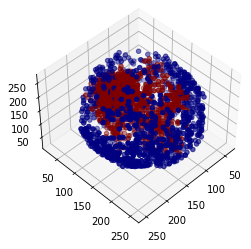

In [3]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure()
ax = plt.axes(projection='3d')

x = particle[0,:]
y = particle[1,:]
z = particle[2,:]
c = particle[6,:]
ax.scatter(x, y, z, c = c, cmap = plt.get_cmap('jet'))
ax.view_init(45, 45)

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=c,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [4]:
##-----------------------------------------------------------------------------
## Load Training data
##-----------------------------------------------------------------------------
# We use h5py as an alternate to scipy.io, because matlab v7.3 files use HDF format.
# Remember h5py.File acts like a Python dictionary.
AtomIntensity = h5py.File('data/dAtomIntensity_TrainData_New.mat', 'r')
print(type(AtomIntensity))
print(list(AtomIntensity.keys()))
Intensity = np.array(AtomIntensity.get('dAtomIntensity_TrainData_New'))
print(Intensity.shape)

<class 'h5py._hl.files.File'>
['dAtomIntensity_TrainData_New']
(2000, 7, 7, 7)


In [5]:
AtomType = scipy.io.loadmat('data/iAtomType_New')
print(type(AtomType))
print(list(AtomType.keys()))
Types = np.array(AtomType['iAtomType_New'])
print(Types.shape)
print(Types[0,:])

<class 'dict'>
['__header__', '__version__', '__globals__', 'iAtomType_New']
(2000, 1)
[1]


In [6]:
##-----------------------------------------------------------------------------
## Training set & Testing set
##-----------------------------------------------------------------------------
# rearrange the order of Intensity & Type
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html
r = np.random.permutation(len(Intensity))
print(r)
x_train = Intensity[r]
x_label = Types[r] -1    # 改成0和1
print("x_train.shape={}, x_label.shape={}".format(x_train.shape, x_label.shape))

for i in range(3):
    print("Before permutation")
    print(r[i], Intensity[r[i],:,1,1])
    print("After permutation")
    print(i, x_train[i,:,1,1])

[1038 1274  936 ...  281 1864  783]
x_train.shape=(2000, 7, 7, 7), x_label.shape=(2000, 1)
Before permutation
1038 [0.2734135  0.12658369 0.3494343  0.79529838 1.01141171 0.72624706
 0.33181691]
After permutation
0 [0.2734135  0.12658369 0.3494343  0.79529838 1.01141171 0.72624706
 0.33181691]
Before permutation
1274 [0.23821597 0.50609127 0.96026789 1.24796586 0.85574428 0.2511963
 0.05278539]
After permutation
1 [0.23821597 0.50609127 0.96026789 1.24796586 0.85574428 0.2511963
 0.05278539]
Before permutation
936 [0.03240398 0.20261218 0.55058931 0.73391161 0.30895302 0.10891976
 0.04538416]
After permutation
2 [0.03240398 0.20261218 0.55058931 0.73391161 0.30895302 0.10891976
 0.04538416]


In [7]:
# Extend one more dim for channel
x_train = x_train.reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[3], 1)
#x_train = x_train.reshape(x_train.shape[0], 7, 7, 7, 1)

# Change label from single value to one-hot vector.
x_label_R = np_utils.to_categorical(x_label, num_classes=2)

print("x_train.shape={}, x_label.shape={}".format(x_train.shape, x_label_R.shape))

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, x_label_R)).batch(32)


x_train.shape=(2000, 7, 7, 7, 1), x_label.shape=(2000, 2)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv3D, MaxPooling3D, LeakyReLU

# https://keras.io/layers/advanced-activations/#leakyrelu
model = Sequential()


In [9]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv3D(filters=32, kernel_size=(3,3,3), padding='same', activation='linear')
    self.leakrelu1 = LeakyReLU(alpha=0.1)
    self.maxpool1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)
    self.conv2 = Conv3D(filters=64, kernel_size=(3,3,3), padding='same', activation='relu')
    self.leakrelu2 = LeakyReLU(alpha=0.1)
    self.maxpool2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)
    self.flatten = Flatten()
    self.d1 = Dense(2048, activation='linear')
    self.leakrelu3 = LeakyReLU(alpha=0.1)
    self.dropout1 = Dropout(0.5)
    self.d2 = Dense(256, activation='linear')
    self.leakrelu4 = LeakyReLU(alpha=0.1)
    self.dropout2 = Dropout(0.5)
    self.d3 = Dense(64, activation='linear')
    self.leakrelu5 = LeakyReLU(alpha=0.1)
    self.dropout3 = Dropout(0.5)
    self.d4 = Dense(2, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.leakrelu1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.leakrelu2(x)
    x = self.maxpool2(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.leakrelu3(x)
    x = self.dropout1(x)
    x = self.d2(x)
    x = self.leakrelu4(x)
    x = self.dropout2(x)
    x = self.d3(x)
    x = self.leakrelu5(x)
    x = self.dropout3(x)
    return self.d4(x)

# Create an instance of the model
model = MyModel()

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
# Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# verbose=2 is recommended when not running interactively
train_history=model.fit(x = x_train, y = x_label_R, validation_split=0.1, epochs=10, batch_size=100, verbose=2)

model.save('my_CNNmodel')  

Epoch 1/10
18/18 - 1s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 1.1921e-09 - val_accuracy: 1.0000
Epoch 2/10
18/18 - 0s - loss: 0.0073 - accuracy: 0.9989 - val_loss: 6.3184e-04 - val_accuracy: 1.0000
Epoch 3/10
18/18 - 0s - loss: 3.5233e-05 - accuracy: 1.0000 - val_loss: 2.9802e-09 - val_accuracy: 1.0000
Epoch 4/10
18/18 - 0s - loss: 8.0766e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
18/18 - 0s - loss: 1.0745e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
18/18 - 0s - loss: 2.7589e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
18/18 - 0s - loss: 1.3110e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/10
18/18 - 0s - loss: 6.2334e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9/10
18/18 - 0s - loss: 1.1815e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 10/10
18/18 - 0s - loss: 2.6781e-07 - accuracy: 

In [14]:
print(model.summary())

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              multiple                  896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) multiple                  0         
_________________________________________________________________
conv3d_1 (Conv3D)            multiple                  55360     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0

In [15]:
# https://keras.io/zh/visualization/
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    legendLoc = 'lower right' if(train=='accuracy') else 'upper right'

    plt.legend(['train', 'validation'], loc=legendLoc)

    plt.show()

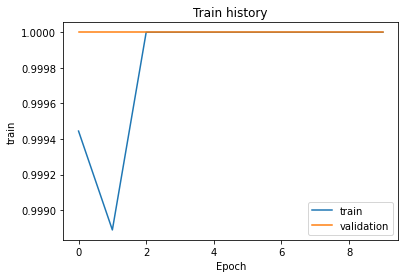

In [16]:
 show_train_history(train_history, 'accuracy', 'val_accuracy')

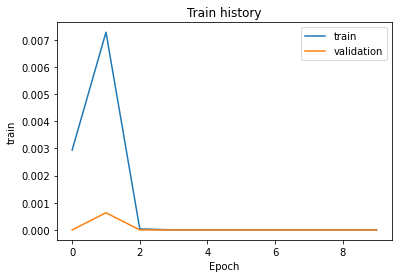

In [17]:
show_train_history(train_history, 'loss', 'val_loss')